# Credit Scoring Flow LangGraph 

**Data Input: standard node** <br>
1. retrieve loan application data. 
2. Check for the data type: age must be integer, and income must be integer or convert it to integer. 

**Loan requirements: conditions node** 
1. Minimum age: 18
2. Minimum income: 10 Fantasy Currency

**Loan Mapping: conditions node**  
| Age Range  | Income Range | Initial Planned Limit |
|------------|--------------|-------------|
| 18–20      | 10–15        | 100         |
| 21–30      | >15          | 500         |
| >30        | >15          | 700         |
| other        | other         | 50         |

**Loan scoring: looping node** 

The initial planned limit will be reduced by the default probability after guessing 3 times
- If the first probability guess is > 0.5, then guess again. 
- The maximum guess attempts are 3 times. If out of these guess all probs > 0.5 then reject. 
- Else, returns the score. 


**Loan disburse: standard node** <br>
disburse the amount by multiplying probs x initial planned limit 




In [1]:
!pip install --quiet langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.6/441.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 8.9 MB/s eta 0:00:00


In [2]:
import math
import random
from typing import TypedDict, List
from decimal import Decimal,ROUND_HALF_UP
from langgraph.graph import StateGraph, END

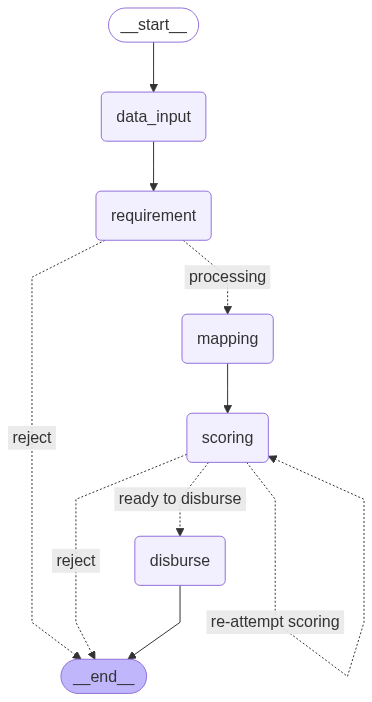

In [3]:
class UserState(TypedDict):
    age: int
    income: int 
    initial_planned_limit: Decimal 
    default_probs: List[Decimal] 
    disburse_amount: Decimal 
    loan_decision: str
    maxdefault: Decimal

def data_input_node(state: UserState) -> UserState:
    state["initial_planned_limit"] = 0
    state["disburse_amount"] = 0
    state["loan_decision"] = "processing"
    state["default_probs"] = []
    state["maxdefault"] = 0.3
    print("Data Input:", state)
    return state

def requirement_node(state: UserState) -> UserState:
    if (state["age"] < 18) or (state["income"] < 10): 
        state["loan_decision"] = "reject"
        print("Rejected due to requirements")
        return state
    print("Meet requirements")
    return state

def route_from_requirement(state: UserState) -> str:
    return state["loan_decision"]  # must return a string: "reject" or "pending"

def mapping_node(state: UserState) -> UserState:
    print("Calculating initial planned amount")
    age = state["age"]
    income = state["income"]

    if 18 <= age <= 20 and 10 <= income <= 15:
        state["initial_planned_limit"] = Decimal("100")
    elif 21 <= age <= 30 and income > 15:
        state["initial_planned_limit"] = Decimal("500")
    elif age > 30 and income > 15:
        state["initial_planned_limit"] = Decimal("700")
    else:
        state["initial_planned_limit"] = Decimal("50")
    return state

def scoring_node(state: UserState) -> UserState:
    state["loan_decision"] = "scoring"
    probs = random.randint(1, 100)/100
    state["default_probs"].append(probs)
    num_attempts = len(state["default_probs"])
    if num_attempts < 3: 
        if probs > state["maxdefault"]: 
            state["loan_decision"] = "re-attempt scoring"
        else:
            state["loan_decision"] = "ready to disburse"
    else:
        if probs > state["maxdefault"]: 
            state["loan_decision"] = "reject"
        else:
            state["loan_decision"] = "ready to disburse"
    return state

def scoring_decision_node(state: UserState) -> str:
    num_attempts = len(state["default_probs"])
    if num_attempts < 3: 
        min_probs = state["default_probs"][-1]
        if min_probs > state["maxdefault"]: 
            print("Re-attempt scoring")
            return "re-attempt scoring"
        else:
            print("Ready to disburse")
            return "ready to disburse"
    else: 
        min_probs = state["default_probs"][-1]
        if min_probs > state["maxdefault"]: 
            print("Rejected because of high default probabilities")
            return "reject"
        else:
            print("Ready to disburse")
            return "ready to disburse"
        
def disburse_node(state: UserState) -> UserState:
    state["disburse_amount"] = (1 - Decimal(state["default_probs"][-1])) * state["initial_planned_limit"]
    state["disburse_amount"] = state["disburse_amount"].quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
    state["loan_decision"] = "disbursed"
    print("Disbursed")
    return state

graph = StateGraph(UserState)
graph.add_node("data_input", data_input_node)
graph.add_node("requirement", requirement_node)
graph.add_node("mapping", mapping_node)
graph.add_node("scoring", scoring_node)
graph.add_node("disburse", disburse_node)

graph.set_entry_point("data_input")
graph.add_edge("data_input", "requirement")
graph.add_conditional_edges(
    "requirement", 
    route_from_requirement,
    {
        "reject": END,
        "processing": "mapping"
    }
)
graph.add_edge("mapping", "scoring")
graph.add_conditional_edges(
    "scoring", 
    scoring_decision_node,
    {
        "reject": END,
        "re-attempt scoring": "scoring",
        "ready to disburse": "disburse"
    }
)

graph.add_edge("disburse", END)
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
result = app.invoke({
    "age":20,
    "income":40
})
result

Data Input: {'age': 20, 'income': 40, 'initial_planned_limit': 0, 'disburse_amount': 0, 'loan_decision': 'processing', 'default_probs': [], 'maxdefault': 0.3}
Meet requirements
Calculating initial planned amount
Re-attempt scoring
Re-attempt scoring
Ready to disburse
Disbursed


{'age': 20,
 'income': 40,
 'initial_planned_limit': Decimal('50'),
 'default_probs': [0.35, 0.63, 0.26],
 'disburse_amount': Decimal('37.00'),
 'loan_decision': 'disbursed',
 'maxdefault': 0.3}